In [6]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as tt
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchsummary
import torchvision as tv

from torchvision import datasets as ds
from torch.utils.data import DataLoader
from torchvision import transforms as ts
import torchvision as tv
import torch
import torch.nn as nn
import math
import numpy as np
from torch.autograd import Variable
from torch import optim
from matplotlib import pyplot as plt
import torch.backends.cudnn as cudnn


from torchvision import datasets # Datasets module
import torchvision.transforms as transforms # Image Transforms
from torch.utils.data.sampler import SubsetRandomSampler # Sampler 
import torch.optim as optim

#transform = tt.ToTensor()
#Alerações Nº1: resize para 224, random rotation(5)
transformnormalized = tt.Compose([tt.Resize(224),
                                tt.RandomRotation(5),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.RandomCrop(224, padding = 10),
                                tt.ToTensor(),
                                tt.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))])
test_transforms = tt.Compose([
                           transforms.Resize(224),
                           transforms.ToTensor(),
                           tt.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))])

#poderiamos usar apenas 0.5 na média e 0.25 na std, mas retirámos estes valores
#do livro "Deep Learning with PyTorch" de  Eli Stevens, onde provavelmente foi 
#feito um estudo de quais seriam os melhores valores.

#este comando não deixa a imagem a preto e branco, nem diminui a quantidade de canais da imagem
#temos à mesma três canais de côr, mas a imagem fica normalizada, onde é possivel distinguir
#com mais facilidade as transições de intensidade entre os pixeis, melhorando o reconhecimento
#de certos objetos.

#adicionei um plot para ter loss curves de validation e training, antes tinhamos so de training
#se nos plots a validation estiver acima da training curve é overfiting, se tiver abiaxo é underfiting

#batch sizes maiores dao tempos de treino mais pequenos porque demora menos tempo a percorrer
#o dataset todo, e temos de fazer menos vezes back propagation, isto acaba por compensar
#o facto de termos de fazer mais calculos nas conv layers com batch sizes maiores.
#(so chegamos a comparar entre batch size de 16 ate 512)

#nao é preciso fazer f-1 curve, so é preciso os valores f1. e isso faz se facilmente
#com uma funçao


#training_data = CIFAR10(download = True , root ="./data", transform = transform)
#testing_data = CIFAR10(root ="./data", train = False , transform = transform)


train_data = CIFAR10(root="./data", transform=transformnormalized, download=True)

# print(len(train_data))
val_data = CIFAR10(root="./data", train=False,transform=transformnormalized)
# print(len(val_data))

testing_data = CIFAR10(root ="./data", train = False , transform = test_transforms)


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
print("Done!")


Files already downloaded and verified
Done!


In [7]:
# Dataset is already divided in training and testing. 
# However, to analize the model over the training step, and also perform cross-validation, the training set must be divided in two parts:
#   Training Set (80%)
#   Validation Set (20%)

# Lets start to obtain training indices
num_train = len(train_data)
#print("Number of images in original training set: " + str(num_train)) # 60 000
indices = list(range(num_train))

# Randomly Shuffle
np.random.shuffle(indices)

# Split 80%/20%
split = int(np.floor(num_train * 0.2)) # 12 000
#print("Split Number: " + str(split))
training_idx, valid_idx = indices[split:], indices[:split] # 48 000 / 12 000


print("Number of training images: " + str(len(training_idx)))
print("Number of validation images: " + str(len(valid_idx)))

# Lets also see how many images are on testing set
print("Number of images in the testing set: " + str(len(testing_data))) # 10 000

Number of training images: 40000
Number of validation images: 10000
Number of images in the testing set: 10000


In [8]:

# To train the network, you must "encode" the data into a PyTorch dataloader
# Since you divided the original training set in 2, now you need to assign the indices to the samples
training_sampler = SubsetRandomSampler(training_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 64 # 16 images per batch

# Training Set
train_loader = torch.utils.data.DataLoader(dataset = train_data, \
                                              batch_size = batch_size, \
                                              sampler = training_sampler)

# Validation Set
valid_loader = torch.utils.data.DataLoader(dataset = train_data, \
                                           batch_size = batch_size, \
                                           sampler = valid_sampler)

# Testing Set
# Here, you do not need the "sampler" input, since you did not change the original testing set
testing_loader = torch.utils.data.DataLoader(dataset = testing_data, \
                                           batch_size = batch_size, \
                                           shuffle = True)


In [9]:
import torchvision.models as models 
num_classes=10;
cnn_model = models.vgg16(pretrained=True)
cnn_model.classifier[6] = nn.Linear(4096,num_classes)

#print("CNN Architecture: "+ str(cnn_model))

torchsummary.summary(cnn_model, input_size = (3, 32, 32), batch_size = 5) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('\nThe model will run on', device)
cnn_model = cnn_model.to(device)


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

In [10]:
# Library imports
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from timeit import default_timer as timer
from datetime import timedelta

start = timer()
end = timer()

# To train a CNN, you must choose (or develop) a loss function, an optimizer algorithm, and a set of hyper-parameters (learning rate, number of epochs, etc)
# Hyper-parameters
lr = 0.01
num_epochs = 25
training_loss=[]

validation_loss=[]
val_loss=0.0
valid_loss_plot=[]
learning_rate=[]
train_accuracy=[]


# Loss Function
criterion = nn.CrossEntropyLoss() # Cross entropy loss function is widely used in classification problems
# Optimizer Algorithm
optimizer = optim.SGD(cnn_model.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)

# Training
running_loss = 0.0
running_loss2 = 0.0

# Adaptive learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1, patience=3, threshold=0.0001, threshold_mode='abs')

for epoch in range(num_epochs):
  running_loss = 0.0
  running_loss2 = 0.0
  for batch_id, data in enumerate(train_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Pass images through the CNN
    outputs = cnn_model(images)

    # Create a loss value
    loss = criterion(outputs, labels)
    

    # Backpropagation
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward()
    optimizer.step()

    # Check some statistics
    running_loss += loss.item()
    running_loss2 += loss.item()
    if batch_id % 125 == 124: # prints every 1000 batchs
      print('[%d, %5d] loss: %.9f' % (epoch + 1, batch_id + 1, running_loss / 125))
      #running_loss2 = running_loss
      running_loss = 0

  train_loss = running_loss2 / len(train_loader)
  training_loss.append(train_loss)
    
  print("[Learning Rate]:".format(epoch + 1),optimizer.param_groups[0]['lr'])
  learning_rate.append(optimizer.param_groups[0]['lr'])

  # For each epoch, analize the model performance
  valid_correct = 0
  valid_total = 0
  valid_total_loss = 0
  with torch.no_grad(): # In this part, you will not train, so you don't need to calculate gradients
    for valid_batch_id, valid_data in enumerate(valid_loader, 0):
      valid_images, valid_labels = valid_data
      valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
      valid_outputs = cnn_model(valid_images)
      valid_loss = criterion(valid_outputs, valid_labels)
      validation_loss.append(valid_loss.item())
      valid_total_loss += valid_loss.item()
      _, valid_predicted = torch.max(valid_outputs.data, 1)
      valid_total += valid_labels.size(0)
      valid_correct += (valid_predicted == valid_labels).sum().item()
    
  val_loss=valid_total_loss/len(valid_loader)
  valid_loss_plot.append(val_loss)
  acc = (100*valid_correct/valid_total)
  train_accuracy.append(acc)
  print("(Validation Set) Epoch: " + str(epoch + 1) + " Loss: " + str(valid_total_loss/ len(valid_idx)) + " Acc: " + str(100*valid_correct/valid_total))
  scheduler.step(loss)
  #scheduler.step(valid_total_loss)  
print("Training is completed!")

end = timer()
str(timedelta(seconds=(end-start)))



[1,   125] loss: 1.723076596
[1,   250] loss: 0.862640213
[1,   375] loss: 0.671204562
[1,   500] loss: 0.552313409
[1,   625] loss: 0.472474800
[Learning Rate]: 0.01
(Validation Set) Epoch: 1 Loss: 0.006442070546746254 Acc: 85.59
[2,   125] loss: 0.430288951
[2,   250] loss: 0.399127156
[2,   375] loss: 0.387585252
[2,   500] loss: 0.345257936
[2,   625] loss: 0.362757084
[Learning Rate]: 0.01
(Validation Set) Epoch: 2 Loss: 0.006348720172047615 Acc: 86.07
[3,   125] loss: 0.296232298
[3,   250] loss: 0.291134321
[3,   375] loss: 0.279257580
[3,   500] loss: 0.281220390
[3,   625] loss: 0.274288337
[Learning Rate]: 0.01
(Validation Set) Epoch: 3 Loss: 0.004597920151799917 Acc: 89.96
[4,   125] loss: 0.226381247
[4,   250] loss: 0.214272574
[4,   375] loss: 0.225984086
[4,   500] loss: 0.208844995
[4,   625] loss: 0.222234403
[Learning Rate]: 0.01
(Validation Set) Epoch: 4 Loss: 0.004151801801472902 Acc: 91.19
[5,   125] loss: 0.171743115
[5,   250] loss: 0.166258344
[5,   375] loss: 0

'5:20:37.400733'

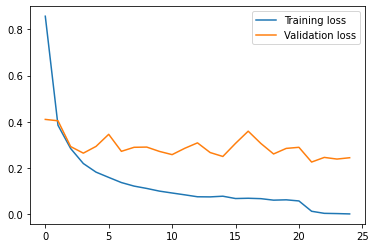

In [11]:
import matplotlib.pyplot as plt
x = np.arange(0, num_epochs, num_epochs/len(training_loss)) # de 0 até num_epochs
plt.plot(x, training_loss)
plt.plot(x, valid_loss_plot)
plt.legend(["Training loss","Validation loss"])
plt.show() 

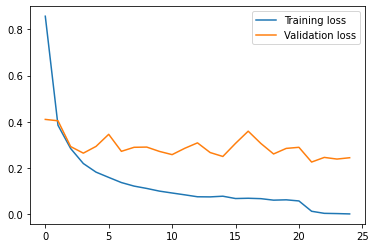

In [12]:
import matplotlib.pyplot as plt
x = np.arange(0, num_epochs, num_epochs/len(training_loss)) # de 0 até num_epochs
plt.plot( training_loss)
plt.plot( valid_loss_plot)
plt.legend(["Training loss","Validation loss"])
plt.show() 

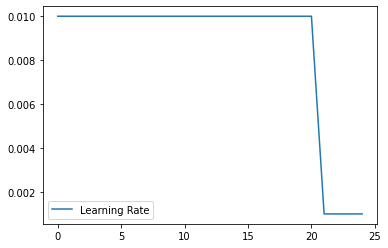

In [13]:
#plot da learning Rate
plt.plot(learning_rate)
plt.legend(["Learning Rate"])
plt.show()

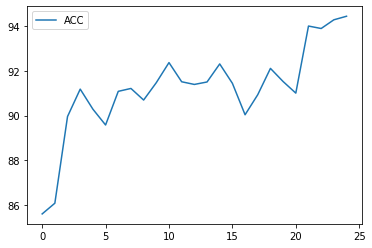

In [14]:
#plot da learning Rate
plt.plot(train_accuracy)
plt.legend(["ACC"])
plt.show()

Accuracy using 10000 test images: 94.46 %

Accuracy of airplane : 94 % in 1036 Images
Accuracy of automobile : 97 % in 1054 Images
Accuracy of bird : 91 % in 938 Images
Accuracy of cat : 89 % in 957 Images
Accuracy of deer : 95 % in 1012 Images
Accuracy of dog : 89 % in 1046 Images
Accuracy of frog : 95 % in 944 Images
Accuracy of horse : 96 % in 1001 Images
Accuracy of ship : 96 % in 1029 Images
Accuracy of truck : 96 % in 983 Images

Confusion Matrix
[[ 979    2   16    6    1    0    0    1   18    7]
 [   1 1026    0    0    0    0    1    0    5   10]
 [  10    0  861    8   10    4   15    5    1    1]
 [   6    1   19  861   12   64   13    8    1    2]
 [   6    0   10   11  967   13    7   12    1    1]
 [   0    0   11   55    6  940    2    6    0    0]
 [   2    0   14   10    5    7  904    1    2    1]
 [   3    0    5    4   11   17    0  963    1    2]
 [  22    7    2    1    0    1    2    2  997   11]
 [   7   18    0    1    0    0    0    3    3  948]]

 MCA total:

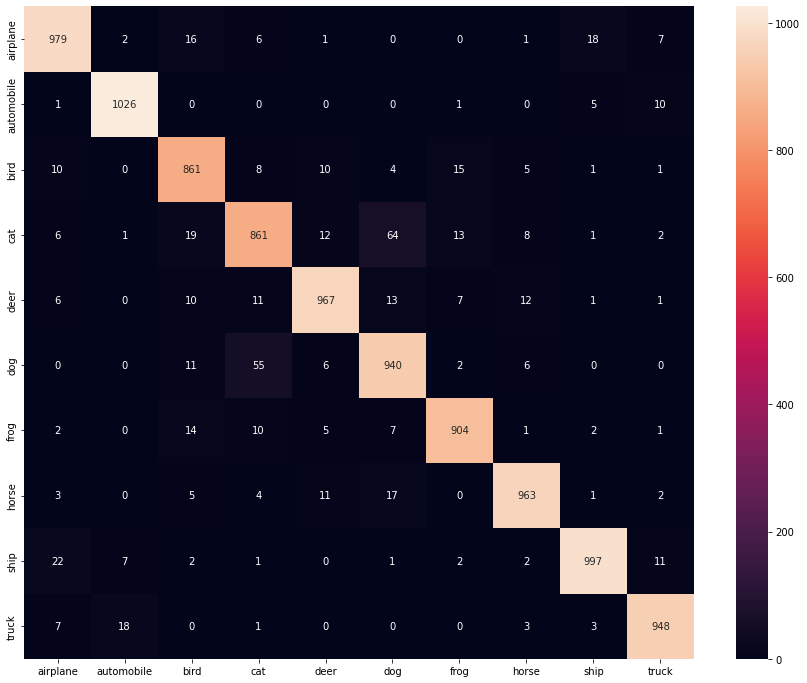

F1 Score of airplane : 0.95
F1 Score of automobile : 0.98
F1 Score of bird : 0.93
F1 Score of cat : 0.89
F1 Score of deer : 0.95
F1 Score of dog : 0.91
F1 Score of frog : 0.96
F1 Score of horse : 0.96
F1 Score of ship : 0.96
F1 Score of truck : 0.97


In [15]:
# Testing

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score

# Evaluate a CNN is similar to the training process without the backpropagation.
# To evaluate a CNN, we need to follow the evaluation metrics
num_classes = 10
correct = 0
total = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
conf_matrix =[[0 for x in range(num_classes)] for y in range(num_classes)]
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
cnn_model.eval()
ytrue=[]
ypred=[]
with torch.no_grad(): # You are not training, so you don't need to calculate gradients
  for batch_id, data in enumerate(valid_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Calculate the CNN's predictions by running images through the network
    outputs = cnn_model(images)

    # The class with the highest
    _, predicted = torch.max(outputs.data, 1)

    # Get model's performance
    #Accuracy
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()

    #Confusion matrix
    for i in range(len(images)):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

    conf_matrix += confusion_matrix(predicted.cpu(), labels.cpu(), labels = [x for x in range(num_classes)])
    ytrue=np.append(ytrue,labels.cpu().numpy())
    ypred=np.append(ypred,predicted.cpu().numpy())

# Show model's performance
print('Accuracy using {} test images: {} %\n'.format(total,100 * correct / total))
# Performance per Class
correct=0
for i in range(num_classes):
  if class_total[i] == 0:
    print('Accuracy of %2s : %2d %% in %d Images' % (i, 0, 0))
  else:
    correct+=class_correct[i]/class_total[i]
    print('Accuracy of %2s : %2d %% in %d Images' % (classes[i], 100 * class_correct[i] / class_total[i], class_total[i]))
  
correct=(correct/10)
correct=correct*100

# Confusion Matrix
print('\nConfusion Matrix')
print(conf_matrix)
print('\n MCA total:%.2f'%correct,'%')

a=pd.DataFrame(conf_matrix,index=[i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,12))
sns.heatmap(a,annot=True,fmt='d')
plt.show()



f1 = f1_score(ytrue,ypred,average=None)
for i in range(num_classes):
  print('F1 Score of %2s : %.2f' % (classes[i], f1[i]))

In [16]:
from timeit import default_timer as timer
from datetime import timedelta
#str(timedelta(seconds=elapsed))
start = timer()
end = timer()
str(timedelta(seconds=(end-start)))

'0:00:00.000015'